In [1]:
import os
import mne
import mne_bids
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from glob import glob
from mne_bids import BIDSPath, find_matching_paths, make_report, print_dir_tree, read_raw_bids

In [2]:
print('MNE–Python version', mne.__version__)
print('MNE–BIDS version', mne_bids.__version__)

MNE–Python version 1.9.0
MNE–BIDS version 0.16.0


### define inputs

In [3]:
'''# on Mac Studio Sharepoint
bids_root = os.path.join('/Users/dsj3886/',
                         'Library/CloudStorage/',
                         'OneDrive-NorthwesternUniversity',
                         'Documents - SoundBrain Lab',
                         'Lab Research Projects/',
                         'Experiments/NU_Experiments/',
                         'EAM1/', 'data-bids')
'''
# on MBA local (copied from Sharepoint)
bids_root = os.path.join('/Users/dsj3886/data_local/',
                        'EAM1_local/data-bids')

print_dir_tree(bids_root)

|data-bids/
|--- .DS_Store
|--- README
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- derivatives/
|------ .DS_Store
|------ sub-02_task-active_run-all_event-stimtrack_epochs.fif
|------ sub-02_task-passive_run-all_event-stimtrack_epochs.fif
|------ sub-03_task-active_run-all_event-stimtrack_epochs.fif
|------ sub-03_task-passive_run-all_event-stimtrack_epochs.fif
|------ sub-04_task-active_run-all_event-stimtrack_epochs.fif
|------ sub-04_task-passive_run-all_event-stimtrack_epochs.fif
|------ sub-05_task-active_run-all_event-stimtrack_epochs.fif
|------ sub-05_task-passive_run-all_event-stimtrack_epochs.fif
|------ sub-06_task-active_run-all_event-stimtrack_epochs.fif
|------ sub-06_task-passive_run-all_event-stimtrack_epochs.fif
|------ sub-07_task-active_run-all_event-stimtrack_epochs.fif
|------ sub-07_task-passive_run-all_event-stimtrack_epochs.fif
|------ sub-08_task-active_run-all_event-stimtrack_epochs.fif
|------ sub-08_task-passive_run-all_ev

In [4]:
# outputs
deriv_dir = os.path.join(bids_root, 'derivatives')



# Combine multiple runs (BIDS)

In [5]:
task_list = ['active', 'passive']

In [6]:
# define function to generate event labels and codes
# (differs per participant)
# TODO: add motor condition
# TODO: fix sub < 13 task-active codes
def generate_event_dict(sub_label, task_label):
    if int(sub_label) > 19:
        event_dict = {'passive/pos': 1,
                    'passive/neg': 2,
                    'active/pos': 3,
                    'active/neg': 4}
    elif int(sub_label) > 13:
        event_dict = {f'{task_label}/pos': 1,
                    f'{task_label}/neg': 2,}
    elif int(sub_label) < 13:
        if task_label == 'passive':
            event_dict = {f'{task_label}/pos': 2049,
                        f'{task_label}/neg': 2050,}
        elif task_label == 'active':
            print('all active coded as 2049.',
                  '  need to fix')
            event_dict = {f'{task_label}/pos': 2049,
                        f'{task_label}/neg': 2050,}
            #pass
    return event_dict

In [7]:
# define event labels and codes (differs per participant)
'''
if int(sub_label) > 19:
    event_dict = {'passive/pos': 1,
                 'passive/neg': 2,
                 'active/pos': 3,
                 'active/neg': 4}
    event_mapping = {1:'passive/pos',
                     2:'passive/neg',
                     3:'active/pos',
                    4:'active/neg'}
elif int(sub_label) > 13:
    event_dict = {'pos': 1,
                  'neg': 2,}
    event_mapping = {1:'pos',
                     2:'neg'}
elif int(sub_label) < 13:
    print('all active coded as 2049.',
         '  need to fix')
    #event_dict = {'pos': 2049,
    #              'neg': 2050,}
'''

# if using stim track event files
event_dict = {'pos': 1,
                'neg': 2,}
event_mapping = {1:'pos',
                    2:'neg'}

In [18]:
sorted(glob(os.path.join(bids_root, 'events-stimtrack')+ 
                                       f'/*{sub_label}*{task_label}*{run_label}_stimtrack_events.tsv'))

[]

In [70]:
bl_start = 0.100
l_freq = 1
h_freq = 15
for sub_num in range(2, 35):
    sub_label = f'{sub_num:02d}'
    '''
    if int(sub_label) > 19:
        event_mapping = {1:'passive/pos',
                        2:'passive/neg',
                        3:'active/pos',
                        4:'active/neg'}
    elif int(sub_label) > 13:
        event_mapping = {1:'pos',
                         2:'neg'}
    else:
        event_mapping = {2049:'pos',
                         2050:'neg'}
    '''
    # initialize an empty dictionary for data
    task_evoked_dict = {}
    event_evoked_dict = {}

    for task_label in task_list:
        print(f'Loading {task_label} data')

        epoch_list = []

        for run_label in range(1,6):
        # load in EEG data
            bids_path = BIDSPath(root=bids_root, datatype='eeg', 
                                 subject=str(sub_label), 
                                 task=task_label, 
                                 run=run_label)
            
            try:
                data = read_raw_bids(bids_path)
                data.load_data()

                # re-reference data to linked mastoid reference
                data_ref = data.set_eeg_reference(ref_channels=['M1', 'M2'])
                
                # filter data
                data_filtered = data_ref.copy().filter(l_freq=l_freq, h_freq=h_freq)


                # loading events from the stim-track-generated events
                events_fpath = sorted(glob(os.path.join(deriv_dir, 'events-stimtrack') + 
                        f'/*{sub_label}*{task_label}*{run_label}_stimtrack_events.tsv'))[0]
                events_df = pd.read_csv(events_fpath, delimiter='\t') 
                annot = mne.Annotations(onset=events_df.onset, duration=0.170, description=events_df.type)
                data_filtered.set_annotations(annot)
                events_from_annot, event_dict2 = mne.events_from_annotations(data_filtered)
                
                # epoch data based on stimulus events
                epochs = mne.Epochs(data_filtered, 
                                    events=events_from_annot, #events, 
                                    event_id=event_dict2, #event_dict,
                                    on_missing='warn',
                                    picks=['Cz'],
                                    tmin=-1*bl_start, tmax=0.4, 
                                    baseline=[-1*bl_start, 0],
                                    reject=dict(eeg=75e-6)).drop_bad()
                
                epoch_list.append(epochs)

            except:
                print(f"No run {run_label} for task-{task_label}")
        
        try:
            # combine epochs across runs
            all_epochs = mne.concatenate_epochs(epoch_list)
        except IndexError:
            print(f'cannot run for sub-{sub_label} task-{task_label} run-{run_label}')

        try:
            out_base = f'sub-{sub_label}_task-{task_label}_baseline-{bl_start}_filt-{l_freq}-{h_freq}_run-all_event-stimtrack_epochs.fif'
            all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)
        except:
            continue


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-02/eeg/sub-02_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-02/eeg/sub-02_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-02/eeg/sub-02_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 16826367  =      0.000 ...  1027.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Not setting metadata
2357 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-02/eeg/sub-02_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-02/eeg/sub-02_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-02/eeg/sub-02_task-passive_run-1_channels.tsv.


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-02_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10551295  =      0.000 ...   644.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Ra

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Not setting metadata
2390 matching events found
Applying baseline correction (mode: mean)
Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-03/eeg/sub-03_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-03/eeg/sub-03_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-03/eeg/sub-03_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-02_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading 0 ... 13221887  =      0.000 ...   807.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 8193 original time points ...
    Rejectin

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1154 events and 8193 original time points ...
Not setting metadata
3367 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-03/eeg/sub-03_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-03/eeg/sub-03_task-passive_run-1_events.tsv.


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-03_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-03/eeg/sub-03_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10518527  =      0.000 ...   642.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline i

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1148 events and 8193 original time points ...
Not setting metadata
3415 matching events found
Applying baseline correction (mode: mean)
Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-active_run-1_events.tsv.


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-03_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 17219583  =      0.000 ...  1051.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline in

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1200 events and 8193 original time points ...
Not setting metadata
3596 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-04_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10452991  =      0.000 ...   638.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1199 events and 8193 original time points ...
Not setting metadata
3594 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-04_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-05/eeg/sub-05_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-05/eeg/sub-05_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-05/eeg/sub-05_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9142271  =      0.000 ...   558.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passba

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1200 events and 8193 original time points ...
Not setting metadata
3590 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-05_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-05/eeg/sub-05_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-05/eeg/sub-05_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-05/eeg/sub-05_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10551295  =      0.000 ...   644.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1197 events and 8193 original time points ...
Not setting metadata
3596 matching events found
Applying baseline correction (mode: mean)
Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-06/eeg/sub-06_task-active_run-1_eeg.bdf...


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-05_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-06/eeg/sub-06_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-06/eeg/sub-06_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 15826943  =      0.000 ...   966.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwid

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1167 events and 8193 original time points ...
Not setting metadata
3516 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-06/eeg/sub-06_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-06_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-06/eeg/sub-06_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-06/eeg/sub-06_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10403839  =      0.000 ...   635.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Not setting metadata
2374 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-06_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-07/eeg/sub-07_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-07/eeg/sub-07_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-07/eeg/sub-07_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 16809983  =      0.000 ...  1026.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Not setting metadata
2291 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-07/eeg/sub-07_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-07/eeg/sub-07_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-07/eeg/sub-07_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10420223  =      0.000 ...   636.000 secs...


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-07_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 8193 original time points ...
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based o

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Not setting metadata
2292 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-07_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)
/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-08_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
No run 1 for task-active
No run 2 for task-active
No run 3 for task-active
No run 4 for task-active
No run 5 for task-active
cannot run for sub-08 task-active run-5
Loading passive data
No run 1 for task-passive
No run 2 for task-passive
No run 3 for task-passive
No run 4 for task-passive
No run 5 for task-passive
cannot run for sub-08 task-passive run-5
Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-09/eeg/sub-09_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-09/eeg/sub-09_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-09/eeg/sub-09_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-08_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading 0 ... 12402687  =      0.000 ...   757.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 8193 original time points ...
    Rejectin

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1197 events and 8193 original time points ...
Not setting metadata
3565 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-09_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-09/eeg/sub-09_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-09/eeg/sub-09_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-09/eeg/sub-09_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10354687  =      0.000 ...   632.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1195 events and 8193 original time points ...
Not setting metadata
3591 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-09_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
No run 1 for task-active
No run 2 for task-active
No run 3 for task-active
No run 4 for task-active
No run 5 for task-active
cannot run for sub-10 task-active run-5
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-10/eeg/sub-10_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-10/eeg/sub-10_task-passive_run-1_events.tsv.


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-10_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-10/eeg/sub-10_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10371071  =      0.000 ...   633.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline i

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1164 events and 8193 original time points ...
Not setting metadata
3487 matching events found
Applying baseline correction (mode: mean)
Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-11/eeg/sub-11_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-10_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-11/eeg/sub-11_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-11/eeg/sub-11_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10715135  =      0.000 ...   654.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.30

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1156 events and 8193 original time points ...
Not setting metadata
3340 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-11/eeg/sub-11_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-11/eeg/sub-11_task-passive_run-1_events.tsv.


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-11_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-11/eeg/sub-11_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10289151  =      0.000 ...   628.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline i

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1069 events and 8193 original time points ...
Not setting metadata
3162 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-11_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)
/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-12_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
No run 1 for task-active
No run 2 for task-active
No run 3 for task-active
No run 4 for task-active
No run 5 for task-active
cannot run for sub-12 task-active run-5
Loading passive data
No run 1 for task-passive
No run 2 for task-passive
No run 3 for task-passive
No run 4 for task-passive
No run 5 for task-passive
cannot run for sub-12 task-passive run-5


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-12_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)
/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-13_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
No run 1 for task-active
No run 2 for task-active
No run 3 for task-active
No run 4 for task-active
No run 5 for task-active
cannot run for sub-13 task-active run-5
Loading passive data
No run 1 for task-passive
No run 2 for task-passive
No run 3 for task-passive
No run 4 for task-passive
No run 5 for task-passive
cannot run for sub-13 task-passive run-5
Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-14/eeg/sub-14_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-14/eeg/sub-14_task-active_run-1_events.tsv.


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-13_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-14/eeg/sub-14_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 14467071  =      0.000 ...   883.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline in

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1050 events and 8193 original time points ...
Using data from preloaded Raw for 1080 events and 8193 original time points ...
Not setting metadata
4295 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-14_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-14/eeg/sub-14_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-14/eeg/sub-14_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-14/eeg/sub-14_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9928703  =      0.000 ...   606.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower pa

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Not setting metadata
2134 matching events found
Applying baseline correction (mode: mean)
Loading active data
No run 1 for task-active
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-15/eeg/sub-15_task-active_run-2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-15/eeg/sub-15_task-active_run-2_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-15/eeg/sub-15_task-active_run-2_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10567679  =      0.000 ...   645.000 secs...


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-14_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 8193 original time points ...
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based o

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1170 events and 8193 original time points ...
Not setting metadata
3525 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-15/eeg/sub-15_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-15/eeg/sub-15_task-passive_run-1_events.tsv.


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-15_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-15/eeg/sub-15_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9945087  =      0.000 ...   607.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline in

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1179 events and 8193 original time points ...
Using data from preloaded Raw for 1169 events and 8193 original time points ...
Not setting metadata
4688 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-15_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-16/eeg/sub-16_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-16/eeg/sub-16_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-16/eeg/sub-16_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10797055  =      0.000 ...   659.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1127 events and 8193 original time points ...
Using data from preloaded Raw for 1149 events and 8193 original time points ...
Using data from preloaded Raw for 1114 events and 8193 original time points ...
Not setting metadata
5702 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-16_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-16/eeg/sub-16_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-16/eeg/sub-16_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-16/eeg/sub-16_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10223615  =      0.000 ...   624.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1159 events and 8193 original time points ...
Using data from preloaded Raw for 1163 events and 8193 original time points ...
Not setting metadata
4644 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-16_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-17/eeg/sub-17_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-17/eeg/sub-17_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-17/eeg/sub-17_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 19857407  =      0.000 ...  1212.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1193 events and 8193 original time points ...
Using data from preloaded Raw for 1194 events and 8193 original time points ...
Not setting metadata
4760 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-17_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-17/eeg/sub-17_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-17/eeg/sub-17_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-17/eeg/sub-17_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9977855  =      0.000 ...   609.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower pa

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1192 events and 8193 original time points ...
Not setting metadata
3572 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-17_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-18/eeg/sub-18_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-18/eeg/sub-18_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-18/eeg/sub-18_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 19644415  =      0.000 ...  1199.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Not setting metadata
2398 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-18/eeg/sub-18_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-18/eeg/sub-18_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-18/eeg/sub-18_task-passive_run-1_channels.tsv.


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-18_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10321919  =      0.000 ...   630.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

No run 1 for task-passive
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-18/eeg/sub-18_task-passive_run-2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure.

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1196 events and 8193 original time points ...
Not setting metadata
3591 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-18_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-19/eeg/sub-19_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-19/eeg/sub-19_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-19/eeg/sub-19_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 12009471  =      0.000 ...   733.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1112 events and 8193 original time points ...
Using data from preloaded Raw for 1126 events and 8193 original time points ...
Using data from preloaded Raw for 1007 events and 8193 original time points ...
Not setting metadata
5520 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-19_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-19/eeg/sub-19_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-19/eeg/sub-19_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-19/eeg/sub-19_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10043391  =      0.000 ...   613.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1109 events and 8193 original time points ...
Using data from preloaded Raw for 1128 events and 8193 original time points ...
Using data from preloaded Raw for 980 events and 8193 original time points ...
Not setting metadata
5463 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-19_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-20/eeg/sub-20_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-20/eeg/sub-20_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-20/eeg/sub-20_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 16334847  =      0.000 ...   997.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1020 events and 8193 original time points ...
Using data from preloaded Raw for 1032 events and 8193 original time points ...
Using data from preloaded Raw for 1080 events and 8193 original time points ...
Not setting metadata
5262 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-20_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-20/eeg/sub-20_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-20/eeg/sub-20_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-20/eeg/sub-20_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9912319  =      0.000 ...   605.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower pa

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 987 events and 8193 original time points ...
Using data from preloaded Raw for 1026 events and 8193 original time points ...
Using data from preloaded Raw for 999 events and 8193 original time points ...
Not setting metadata
5149 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-20_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-21/eeg/sub-21_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-21/eeg/sub-21_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-21/eeg/sub-21_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 7045119  =      0.000 ...   430.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passba

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1189 events and 8193 original time points ...
Not setting metadata
3575 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-21/eeg/sub-21_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-21/eeg/sub-21_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-21/eeg/sub-21_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-21_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading 0 ... 9928703  =      0.000 ...   606.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 8193 original time points ...
    Rejecting

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1196 events and 8193 original time points ...
Using data from preloaded Raw for 1193 events and 8193 original time points ...
Not setting metadata
4692 matching events found
Applying baseline correction (mode: mean)
Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-22/eeg/sub-22_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-21_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-22/eeg/sub-22_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-22/eeg/sub-22_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 14204927  =      0.000 ...   867.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.30

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1191 events and 8193 original time points ...
Not setting metadata
3561 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-22/eeg/sub-22_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-22/eeg/sub-22_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-22/eeg/sub-22_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-22_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading 0 ... 9977855  =      0.000 ...   609.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 8193 original time points ...
    Rejecting

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1160 events and 8193 original time points ...
Using data from preloaded Raw for 1121 events and 8193 original time points ...
Not setting metadata
4670 matching events found
Applying baseline correction (mode: mean)
Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-23/eeg/sub-23_task-active_run-1_eeg.bdf...
BDF file detected


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-22_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-23/eeg/sub-23_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-23/eeg/sub-23_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 14417919  =      0.000 ...   880.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1184 events and 8193 original time points ...
Not setting metadata
3563 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-23/eeg/sub-23_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-23/eeg/sub-23_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-23/eeg/sub-23_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-23_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading 0 ... 11124735  =      0.000 ...   679.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 8193 original time points ...
    Rejectin

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1176 events and 8193 original time points ...
Using data from preloaded Raw for 1156 events and 8193 original time points ...
Not setting metadata
4719 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-23_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-24/eeg/sub-24_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-24/eeg/sub-24_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-24/eeg/sub-24_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 16056319  =      0.000 ...   980.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1137 events and 8193 original time points ...
Using data from preloaded Raw for 897 events and 8193 original time points ...
Using data from preloaded Raw for 43 events and 8193 original time points ...
Not setting metadata
4451 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-24_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-24/eeg/sub-24_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-24/eeg/sub-24_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-24/eeg/sub-24_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10141695  =      0.000 ...   619.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1133 events and 8193 original time points ...
Using data from preloaded Raw for 948 events and 8193 original time points ...
Not setting metadata
4455 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-24_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-25/eeg/sub-25_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-25/eeg/sub-25_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-25/eeg/sub-25_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 18546687  =      0.000 ...  1132.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1170 events and 8193 original time points ...
Not setting metadata
3510 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-25/eeg/sub-25_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-25/eeg/sub-25_task-passive_run-1_events.tsv.


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-25_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-25/eeg/sub-25_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9945087  =      0.000 ...   607.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline in

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1159 events and 8193 original time points ...
Using data from preloaded Raw for 1162 events and 8193 original time points ...
Not setting metadata
4656 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-25_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-26/eeg/sub-26_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-26/eeg/sub-26_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-26/eeg/sub-26_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10452991  =      0.000 ...   638.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1192 events and 8193 original time points ...
Using data from preloaded Raw for 1166 events and 8193 original time points ...
Using data from preloaded Raw for 1194 events and 8193 original time points ...
Not setting metadata
5914 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-26_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-26/eeg/sub-26_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-26/eeg/sub-26_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-26/eeg/sub-26_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9912319  =      0.000 ...   605.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower pa

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1194 events and 8193 original time points ...
Using data from preloaded Raw for 1029 events and 8193 original time points ...
Using data from preloaded Raw for 1198 events and 8193 original time points ...
Not setting metadata
5814 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-26_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-27/eeg/sub-27_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-27/eeg/sub-27_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-27/eeg/sub-27_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 7520255  =      0.000 ...   459.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passba

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1199 events and 8193 original time points ...
Not setting metadata
3594 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-27/eeg/sub-27_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-27/eeg/sub-27_task-passive_run-1_events.tsv.


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-27_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-27/eeg/sub-27_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9895935  =      0.000 ...   604.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline in

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1198 events and 8193 original time points ...
Using data from preloaded Raw for 1167 events and 8193 original time points ...
Not setting metadata
4757 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-27_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-28/eeg/sub-28_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-28/eeg/sub-28_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-28/eeg/sub-28_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 16826367  =      0.000 ...  1027.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1200 events and 8193 original time points ...
Not setting metadata
3599 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-28/eeg/sub-28_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-28/eeg/sub-28_task-passive_run-1_events.tsv.


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-28_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-28/eeg/sub-28_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9863167  =      0.000 ...   602.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline in

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1199 events and 8193 original time points ...
Not setting metadata
3599 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-28_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-29/eeg/sub-29_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-29/eeg/sub-29_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-29/eeg/sub-29_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 11239423  =      0.000 ...   686.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1179 events and 8193 original time points ...
Using data from preloaded Raw for 1183 events and 8193 original time points ...
Using data from preloaded Raw for 1175 events and 8193 original time points ...
Not setting metadata
5922 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-29_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-29/eeg/sub-29_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-29/eeg/sub-29_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-29/eeg/sub-29_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9912319  =      0.000 ...   605.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower pa

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1187 events and 8193 original time points ...
Using data from preloaded Raw for 1181 events and 8193 original time points ...
Not setting metadata
4719 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-29_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-30/eeg/sub-30_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-30/eeg/sub-30_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-30/eeg/sub-30_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10518527  =      0.000 ...   642.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1188 events and 8193 original time points ...
Using data from preloaded Raw for 1174 events and 8193 original time points ...
Using data from preloaded Raw for 1193 events and 8193 original time points ...
Not setting metadata
5937 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-30_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-30/eeg/sub-30_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-30/eeg/sub-30_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-30/eeg/sub-30_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9945087  =      0.000 ...   607.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower pa

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1192 events and 8193 original time points ...
Using data from preloaded Raw for 1189 events and 8193 original time points ...
Using data from preloaded Raw for 1194 events and 8193 original time points ...
Not setting metadata
5962 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-30_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-31/eeg/sub-31_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-31/eeg/sub-31_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-31/eeg/sub-31_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 16383999  =      0.000 ...  1000.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Not setting metadata
2369 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-31/eeg/sub-31_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-31/eeg/sub-31_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-31/eeg/sub-31_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10092543  =      0.000 ...   616.000 secs...


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-31_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 8193 original time points ...
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based o

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1172 events and 8193 original time points ...
Not setting metadata
3511 matching events found
Applying baseline correction (mode: mean)
Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-32/eeg/sub-32_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-32/eeg/sub-32_task-active_run-1_events.tsv.


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-31_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-32/eeg/sub-32_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10010623  =      0.000 ...   611.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 54069 samples (3.300 s)

Used Annotations descriptions: ['1', '2']
Not setting metadata
1200 matching events found
Setting baseline in

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 837 events and 8193 original time points ...
Using data from preloaded Raw for 915 events and 8193 original time points ...
Using data from preloaded Raw for 916 events and 8193 original time points ...
Not setting metadata
4720 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-32_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-32/eeg/sub-32_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-32/eeg/sub-32_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-32/eeg/sub-32_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10108927  =      0.000 ...   617.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1010 events and 8193 original time points ...
Using data from preloaded Raw for 1005 events and 8193 original time points ...
Not setting metadata
4873 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-32_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-33/eeg/sub-33_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-33/eeg/sub-33_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-33/eeg/sub-33_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 17498111  =      0.000 ...  1068.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1179 events and 8193 original time points ...
Using data from preloaded Raw for 1176 events and 8193 original time points ...
Not setting metadata
4730 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-33_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-33/eeg/sub-33_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-33/eeg/sub-33_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-33/eeg/sub-33_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9945087  =      0.000 ...   607.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower pa

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1165 events and 8193 original time points ...
Using data from preloaded Raw for 1168 events and 8193 original time points ...
Not setting metadata
4610 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-33_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-34/eeg/sub-34_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-34/eeg/sub-34_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-34/eeg/sub-34_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 21987327  =      0.000 ...  1342.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1174 events and 8193 original time points ...
Using data from preloaded Raw for 1158 events and 8193 original time points ...
Using data from preloaded Raw for 1151 events and 8193 original time points ...
Not setting metadata
5830 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-34_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-34/eeg/sub-34_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-34/eeg/sub-34_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-34/eeg/sub-34_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9945087  =      0.000 ...   607.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower pa

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:71: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Using data from preloaded Raw for 1172 events and 8193 original time points ...
Using data from preloaded Raw for 1185 events and 8193 original time points ...
Using data from preloaded Raw for 1180 events and 8193 original time points ...
Not setting metadata
5907 matching events found
Applying baseline correction (mode: mean)


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/2931040719.py:77: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-34_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)


# Combine participants

In [71]:

glob(deriv_dir+f'/*baseline-{bl_start}_*filt-{l_freq}-{h_freq}*stim*fif')

['/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-08_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-11_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-20_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-05_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-34_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-04_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-06_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj388

In [73]:
act_pos_avgs = []
act_neg_avgs = []
#act_eps = [sorted(glob(deriv_dir+f'/sub-{sub_num:02d}_task-active_run-all_epochs.fif') for sub_num in range(2,13))]
act_eps = [sorted(glob(deriv_dir+f'/sub-{sub_num:02d}_task-active_baseline-{bl_start}_filt-{l_freq}-{h_freq}_run-all_event-stimtrack_epochs.fif') for sub_num in range(2,35))]
for act_ep in act_eps[0]:
    try:
        sub_active_epochs = mne.read_epochs(act_ep[0])
        act_pos_avgs.append(sub_active_epochs['1'].average())
        act_neg_avgs.append(sub_active_epochs['2'].average())
    except:
        pass

pas_pos_avgs = []
pas_neg_avgs = []
#pas_eps = [sorted(glob(deriv_dir+f'/sub-{sub_num:02d}_task-passive_run-all_epochs.fif') for sub_num in range(2,13))]
pas_eps = [sorted(glob(deriv_dir+f'/sub-{sub_num:02d}_task-passive_baseline-{bl_start}_filt-{l_freq}-{h_freq}_run-all_event-stimtrack_epochs.fif') for sub_num in range(2,35))]
for pas_ep in pas_eps[0]:
    try:
        sub_passive_epochs = mne.read_epochs(pas_ep[0])
        pas_pos_avgs.append(sub_passive_epochs['1'].average())
        pas_neg_avgs.append(sub_passive_epochs['2'].average())
    except:
        pass


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-02_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
2357 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-03_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-02_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])
/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-03_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3367 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-04_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3596 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-04_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-05_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3590 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-05_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-06_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3516 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-06_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-07_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
2291 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-08_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-07_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])
/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-08_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
2292 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-09_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3565 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-09_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-10_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3591 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-10_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-11_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3340 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-11_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-12_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3162 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-12_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-13_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3162 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-13_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-14_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
4295 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-14_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-15_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3525 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-15_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-16_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-16_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Not setting metadata
5702 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-17_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
4760 matching events found
No baseline correction applied


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-17_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-18_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
2398 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-19_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-18_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])
/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-19_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
5520 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-20_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-20_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Not setting metadata
5262 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-21_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3575 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-21_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-22_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3561 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-22_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-23_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3563 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-23_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-24_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
4451 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-24_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-25_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3510 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-25_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-26_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-26_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Not setting metadata
5914 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-27_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3594 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-27_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-28_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3599 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-28_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-29_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-29_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Not setting metadata
5922 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-30_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-30_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Not setting metadata
5937 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-31_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
2369 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-32_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-31_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])
/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-32_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
4720 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-33_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
4730 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-33_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-34_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:7: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-34_task-active_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0])


Not setting metadata
5830 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-02_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
2390 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-03_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-02_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])
/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-03_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3415 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-04_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3594 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-04_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-05_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3596 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-05_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-06_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
2374 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-07_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-06_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])
/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-07_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Not setting metadata
2292 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-08_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
2292 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-09_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-08_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])
/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-09_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Not setting metadata
3591 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-10_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3487 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-10_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-11_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3162 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-11_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-12_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3162 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-12_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-13_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3162 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-13_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-14_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
2134 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-14_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-15_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-15_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Not setting metadata
4688 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-16_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-16_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Not setting metadata
4644 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-17_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3572 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-17_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-18_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3591 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-18_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-19_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-19_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Not setting metadata
5463 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-20_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-20_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Not setting metadata
5149 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-21_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
4692 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-21_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-22_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
4670 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-22_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-23_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
4719 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-23_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-24_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
4455 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-24_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-25_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-25_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Not setting metadata
4656 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-26_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-26_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Not setting metadata
5814 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-27_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
4757 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-27_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-28_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3599 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-28_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-29_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
4719 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-29_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-30_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-30_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Not setting metadata
5962 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-31_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
3511 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-31_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-32_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
4873 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-32_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-33_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-33_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Not setting metadata
4610 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-34_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -99.98 ...     400.02 ms
        0 CTF compensation matrices available


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/3910088947.py:19: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-34_task-passive_baseline-0.1_filt-1-15_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(pas_ep[0])


Not setting metadata
5907 matching events found
No baseline correction applied
0 projection items activated


In [74]:
act_pos_avgs

[<Evoked | '1' (average, N=1179), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1685), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1798), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1798), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1760), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1145), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1140), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1778), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1796), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1670), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1578), -0.099976 – 0.40002 s, bas

In [75]:
pas_pos_grandavg = mne.grand_average(pas_pos_avgs)
pas_neg_grandavg = mne.grand_average(pas_neg_avgs)
act_pos_grandavg = mne.grand_average(act_pos_avgs)
act_neg_grandavg = mne.grand_average(act_neg_avgs)

passive_grandavg = mne.grand_average(pas_pos_avgs+pas_neg_avgs)
active_grandavg = mne.grand_average(act_pos_avgs+act_neg_avgs)

Identifying common channels ...


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


In [80]:
passive_grandavg

<Evoked | 'Grand average (n = 66)' (average, N=66), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~71 KiB>

## Combined polarities

In [78]:
evokeds = dict(passive=passive_grandavg, active=active_grandavg)

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/382484298.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, truncate_xaxis=False) #, picks='Cz', combine='mean', ci=0.95)


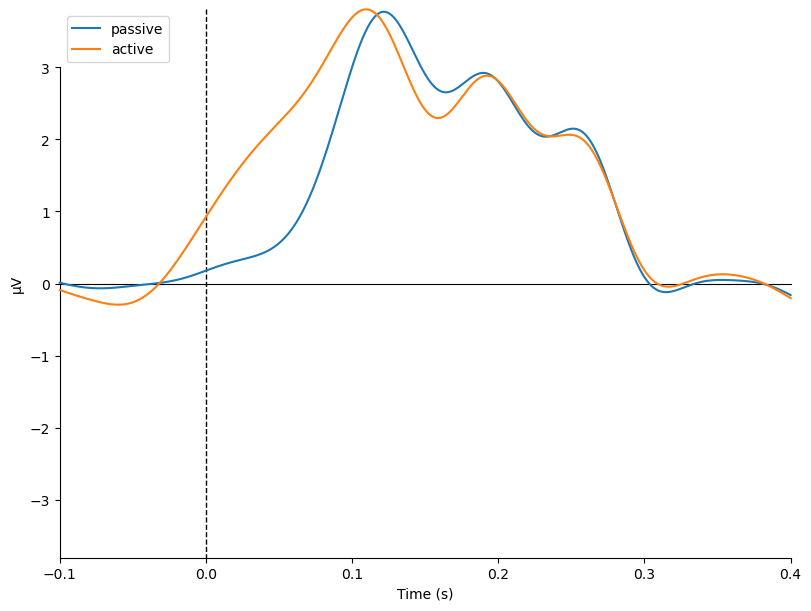

[<Figure size 800x600 with 1 Axes>]

In [79]:
mne.viz.plot_compare_evokeds(evokeds, truncate_xaxis=False) #, picks='Cz', combine='mean', ci=0.95)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


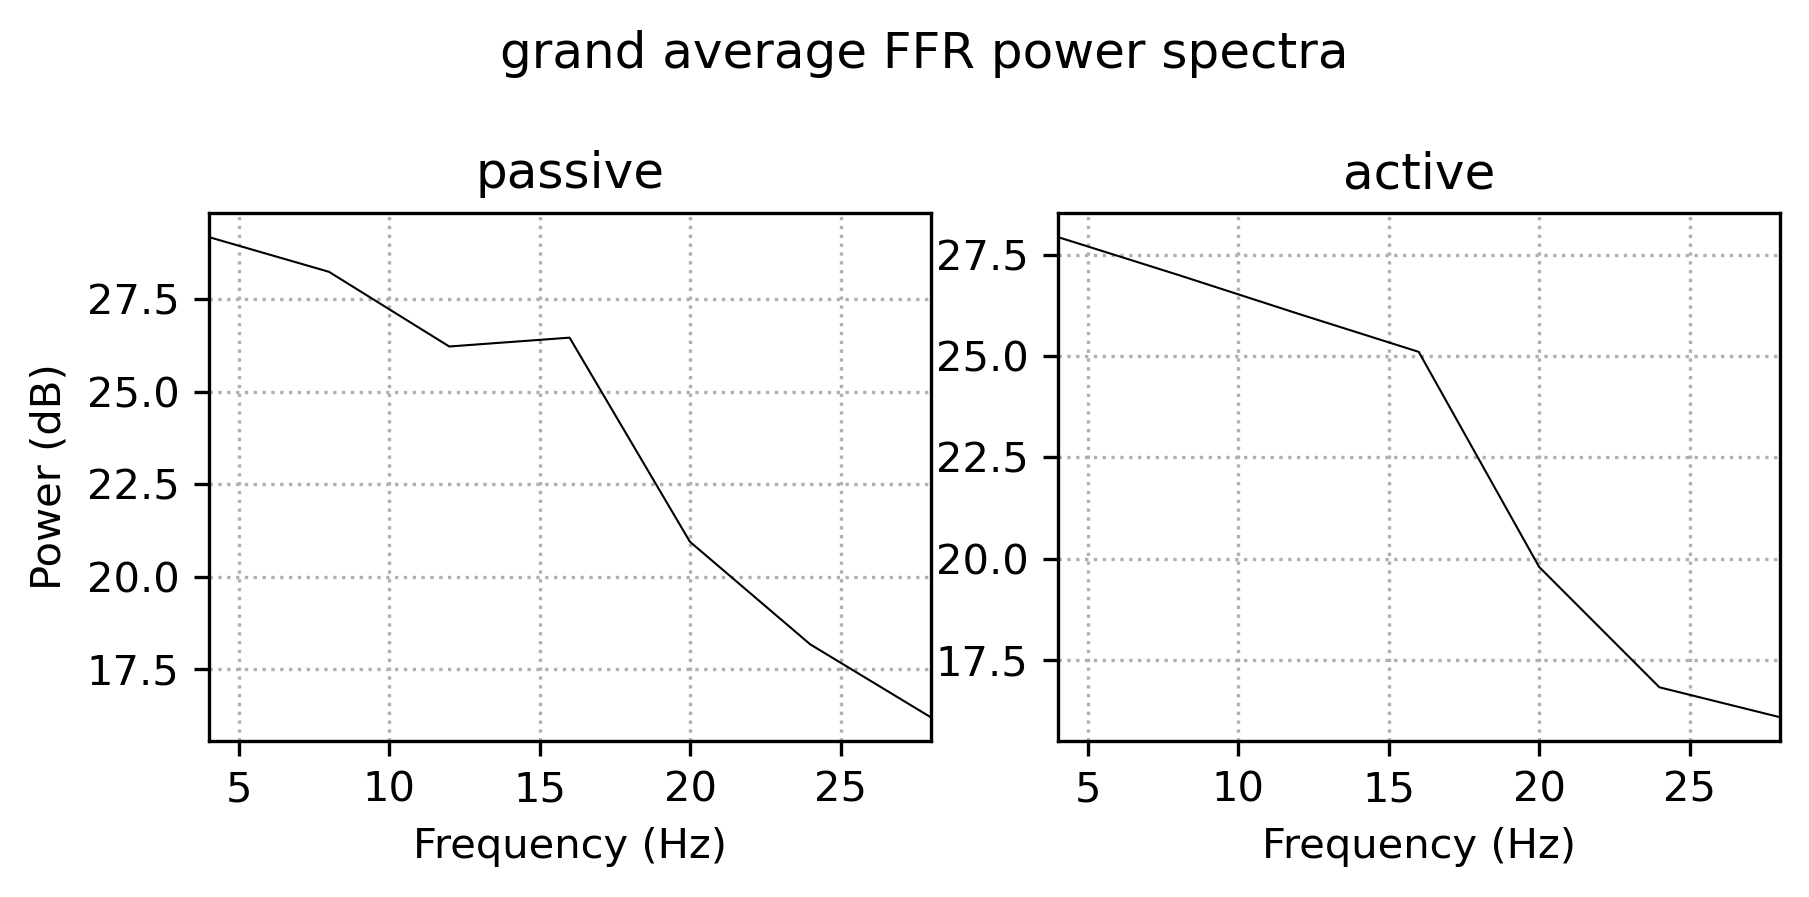

In [61]:
# Power spectra
passive_psd = passive_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=1, fmax=30)
active_psd = active_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=1, fmax=30)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=300)
ax = axes.flatten()
passive_psd.plot(axes=ax[0], amplitude=False, average=True, show=False)
active_psd.plot(axes=ax[1], amplitude=False, average=True, show=False)
#active_neg_psd.plot(axes=ax[3], amplitude=False, average=True, show=False)

ax[0].set_title('passive')
ax[1].set_title('active')

ax[0].set_ylabel('Power (dB)')
ax[0].set_xlabel('Frequency (Hz)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle(f'grand average FFR power spectra')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

In [63]:
# Spectrograms
frequencies = np.arange(1, 30)

passive_power = passive_grandavg.compute_tfr('multitaper', freqs=frequencies)
active_power = active_grandavg.compute_tfr('multitaper', freqs=frequencies)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=200)
ax = axes.flatten()
passive_power.plot(axes=ax[0], tmax=0.4, vlim=[0, 5e-12], show=False)
active_power.plot(axes=ax[1], tmax=0.4, vlim=[0, 5e-12], show=False)

ax[0].set_title('passive');
ax[1].set_title('active');


fig.suptitle(f'FFR spectrograms')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectrograms.svg')

ValueError: At least one of the wavelets is longer than the signal. Use a longer signal or shorter wavelets.

### RMS SNR

In [31]:
from numpy import mean, sqrt, square

In [32]:
task_evoked_dict = {}
task_evoked_dict['passive'] = passive_grandavg
task_evoked_dict['active']  = active_grandavg

In [35]:
for sx, stim in enumerate(task_evoked_dict):
    s_evoked = task_evoked_dict[stim]
    baseline_ind_bounds = s_evoked.time_as_index(task_evoked_dict[stim].baseline)
    response_ind_bounds = s_evoked.time_as_index([0.100, 0.300])

    evoked_baseline = s_evoked.data[0,baseline_ind_bounds[0]:baseline_ind_bounds[1]]
    evoked_response = s_evoked.data[0,response_ind_bounds[0]:response_ind_bounds[1]]
    rms_baseline = sqrt(mean(square(evoked_baseline)))
    rms_response = sqrt(mean(square(evoked_response)))

    rms_snr = rms_response / rms_baseline

    print(f'{stim} RMS SNR: {rms_snr:.04f}')


passive RMS SNR: 49.3664
active RMS SNR: 6.7447


## Individual polarities

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/852109899.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds([pas_pos_grandavg,pas_neg_grandavg,act_pos_grandavg, act_neg_grandavg],


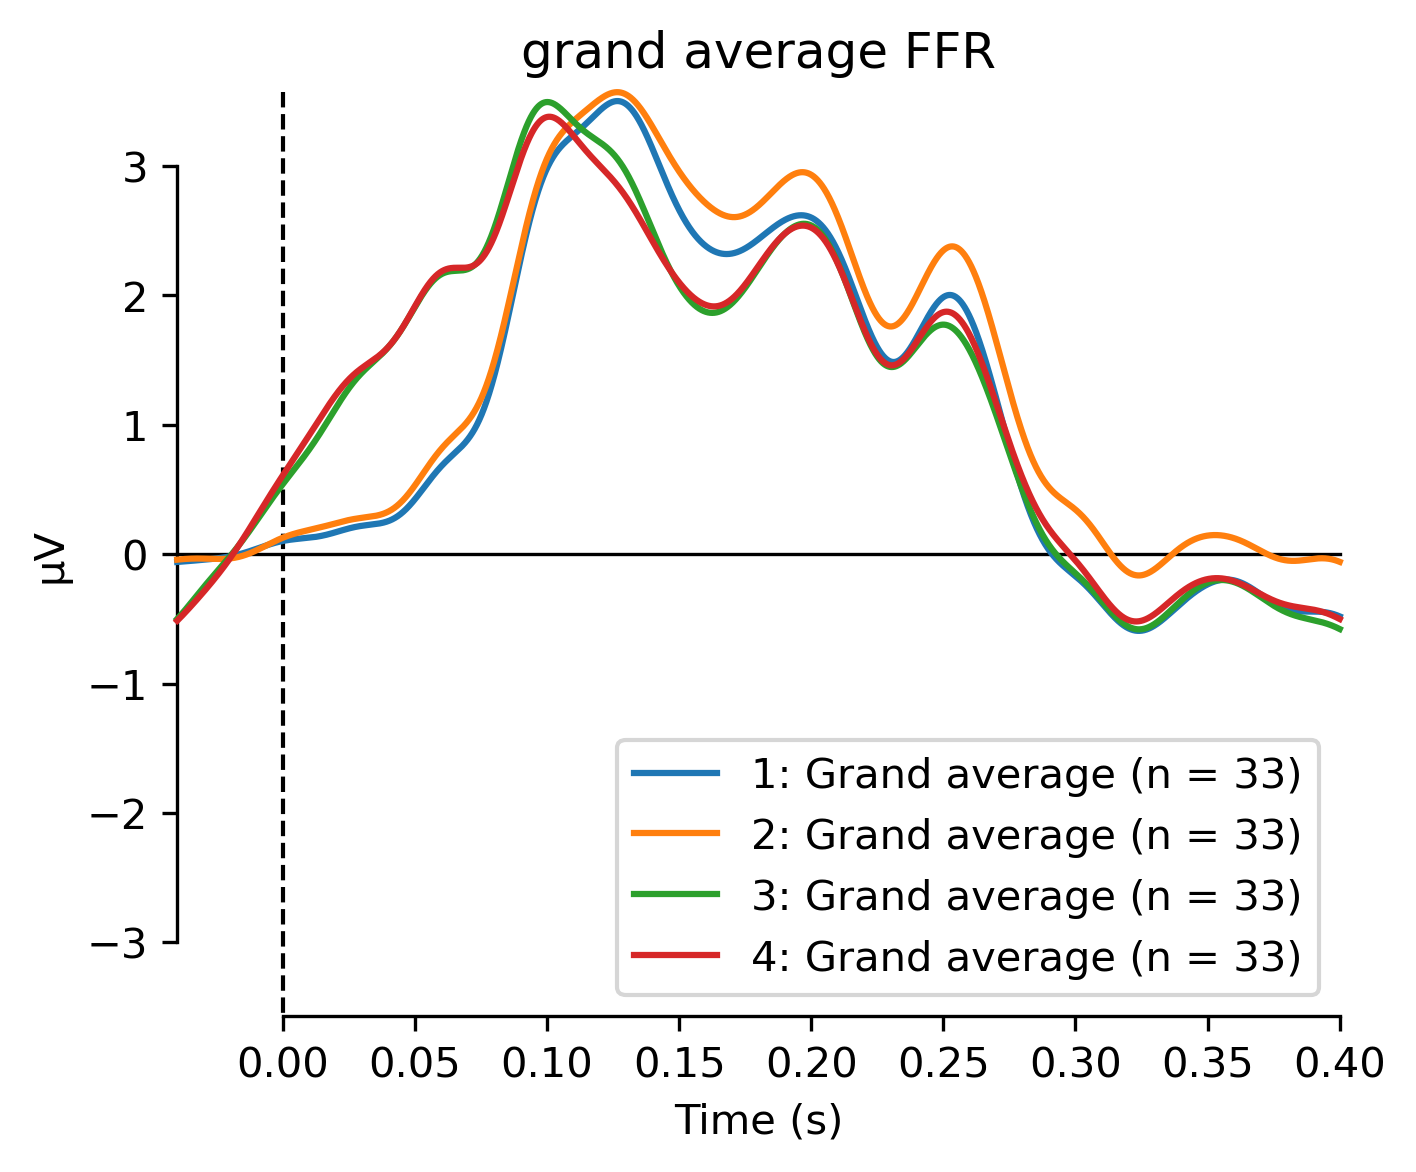

[<Figure size 1500x1200 with 1 Axes>]

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=300)
#ax.legend(['passive/positive', 'passive/negative', 'active/positive', 'active/negative'], loc="upper right")
mne.viz.plot_compare_evokeds([pas_pos_grandavg,pas_neg_grandavg,act_pos_grandavg, act_neg_grandavg],
                             legend='lower right',
                             title='grand average FFR',
                             axes=ax)

Text(0.5, 1.0, 'active/negative')

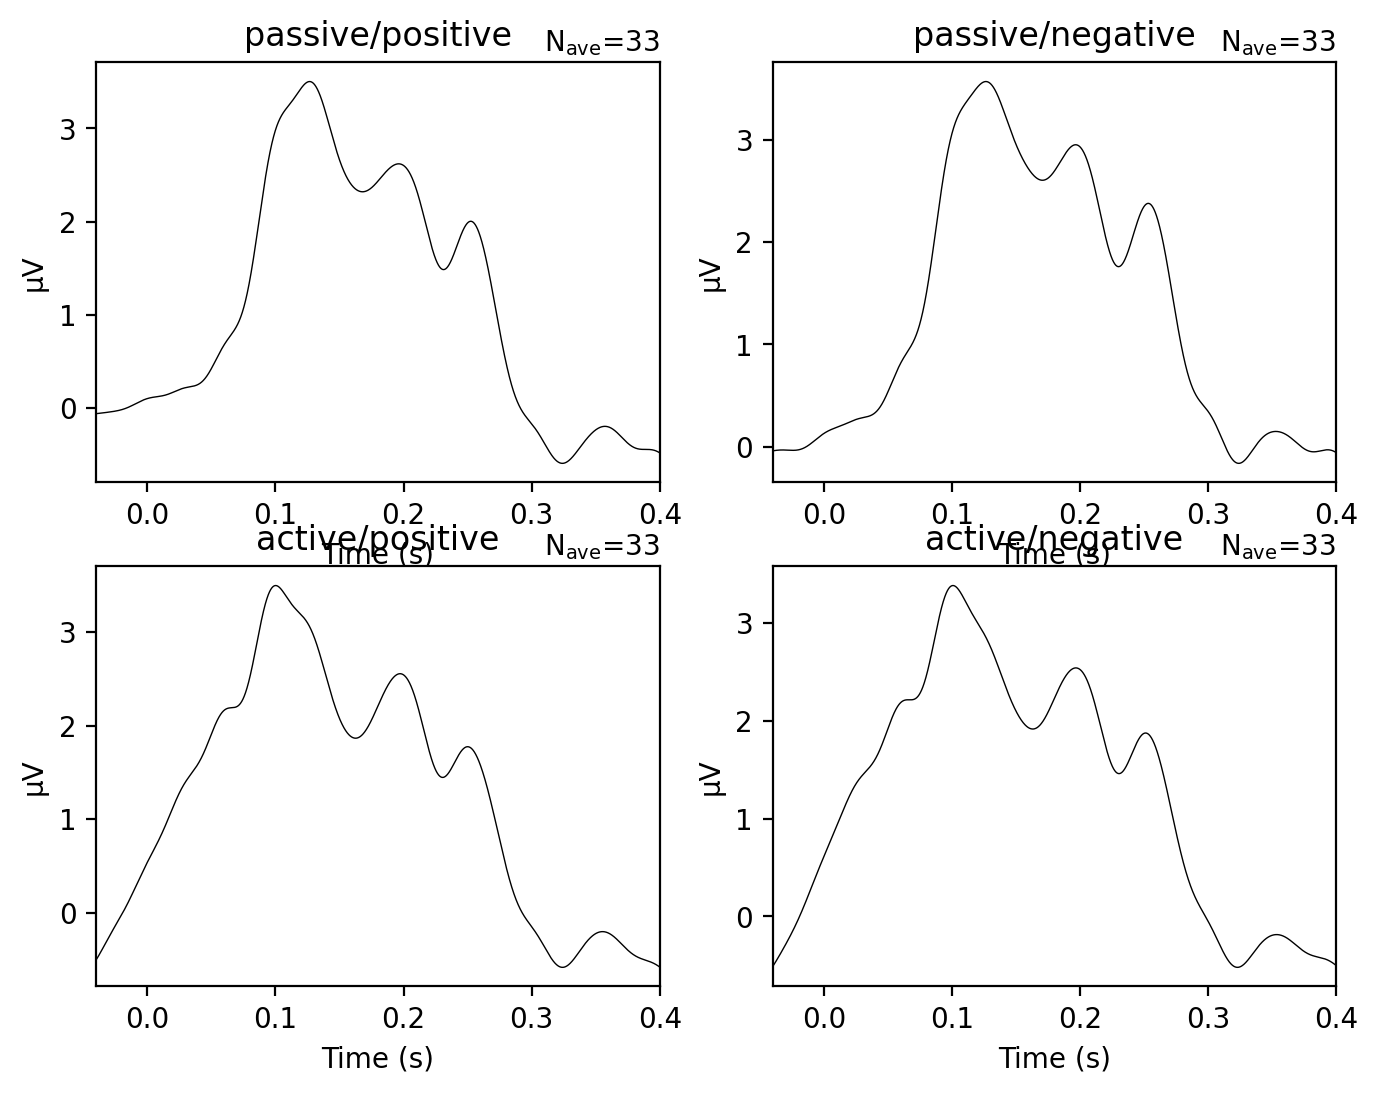

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
pas_pos_grandavg.plot(axes=ax[0], selectable=False, show=False)
pas_neg_grandavg.plot(axes=ax[1], selectable=False, show=False)
act_pos_grandavg.plot(axes=ax[2], selectable=False, show=False)
act_neg_grandavg.plot(axes=ax[3], selectable=False, show=False)

ax[0].set_title('passive/positive')
ax[1].set_title('passive/negative')
ax[2].set_title('active/positive')
ax[3].set_title('active/negative')

In [ ]:
# Power spectra
passive_pos_psd = pas_pos_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
passive_neg_psd = pas_neg_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
active_pos_psd = act_pos_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
active_neg_psd = act_neg_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)

fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
passive_pos_psd.plot(axes=ax[0], amplitude=False, average=True, show=False)
passive_neg_psd.plot(axes=ax[1], amplitude=False, average=True, show=False)
active_pos_psd.plot(axes=ax[2], amplitude=False, average=True, show=False)
active_neg_psd.plot(axes=ax[3], amplitude=False, average=True, show=False)

ax[0].set_title('pass/pos');
ax[1].set_title('pass/neg');
ax[2].set_title('act/pos');
ax[3].set_title('act/neg');

fig.suptitle(f'grand average FFR power spectra')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

In [40]:
# Spectrograms
passive_pos_power = pas_pos_grandavg.compute_tfr(method="", freqs=frequencies)
passive_neg_power = pas_neg_grandavg.compute_tfr("morlet", freqs=frequencies)
active_pos_power  = act_pos_grandavg.compute_tfr("morlet", freqs=frequencies)
active_neg_power  = act_neg_grandavg.compute_tfr("morlet", freqs=frequencies)

fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
passive_pos_power.plot(axes=ax[0], tmax=0.4, vlim=[0, 5e-12], show=False)
passive_neg_power.plot(axes=ax[1], tmax=0.4, vlim=[0, 5e-12], show=False)
active_pos_power.plot(axes=ax[2], tmax=0.4, vlim=[0, 5e-12], show=False)
active_neg_power.plot(axes=ax[3], tmax=0.4, vlim=[0, 5e-12], show=False)

ax[0].set_title('pass/pos');
ax[1].set_title('pass/neg');
ax[2].set_title('act/pos');
ax[3].set_title('act/neg');

fig.suptitle(f'grand average FFR spectrograms')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

ValueError: Invalid value for the 'method' parameter. Allowed values are 'morlet' and 'multitaper', but got '' instead.

# Single subject plots

### load epochs

In [41]:
sub_label = '02'
active_epochs = glob(deriv_dir+f'/sub-{sub_label}_task-active_filt-1-30_run-all_event-stimtrack_epochs.fif')[0]
passive_epochs = glob(deriv_dir+f'/sub-{sub_label}_task-passive_filt-1-30_run-all_event-stimtrack_epochs.fif')[0]

In [42]:
sub_active_epochs = mne.read_epochs(active_epochs)
sub_active_evoked = sub_active_epochs.average()
sub_active_events_evoked = sub_active_epochs.average(by_event_type=True)

sub_passive_epochs = mne.read_epochs(passive_epochs)
sub_passive_evoked = sub_passive_epochs.average()
sub_passive_events_evoked = sub_passive_epochs.average(by_event_type=True)

event_evoked_dict = {}
event_evoked_dict['passive'] = sub_passive_events_evoked
event_evoked_dict['active'] = sub_active_events_evoked

Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-02_task-active_filt-1-30_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -39.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
2332 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/1638994838.py:1: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-02_task-active_filt-1-30_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(active_epochs)


Reading /Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-02_task-passive_filt-1-30_run-all_event-stimtrack_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -39.98 ...     400.02 ms
        0 CTF compensation matrices available
Not setting metadata
2382 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/1638994838.py:5: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-02_task-passive_filt-1-30_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(passive_epochs)


### Plot individual polarities

In [43]:
event_evoked_dict

{'passive': [<Evoked | '1' (average, N=1192), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
  <Evoked | '2' (average, N=1190), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>],
 'active': [<Evoked | '1' (average, N=1169), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
  <Evoked | '2' (average, N=1163), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>]}

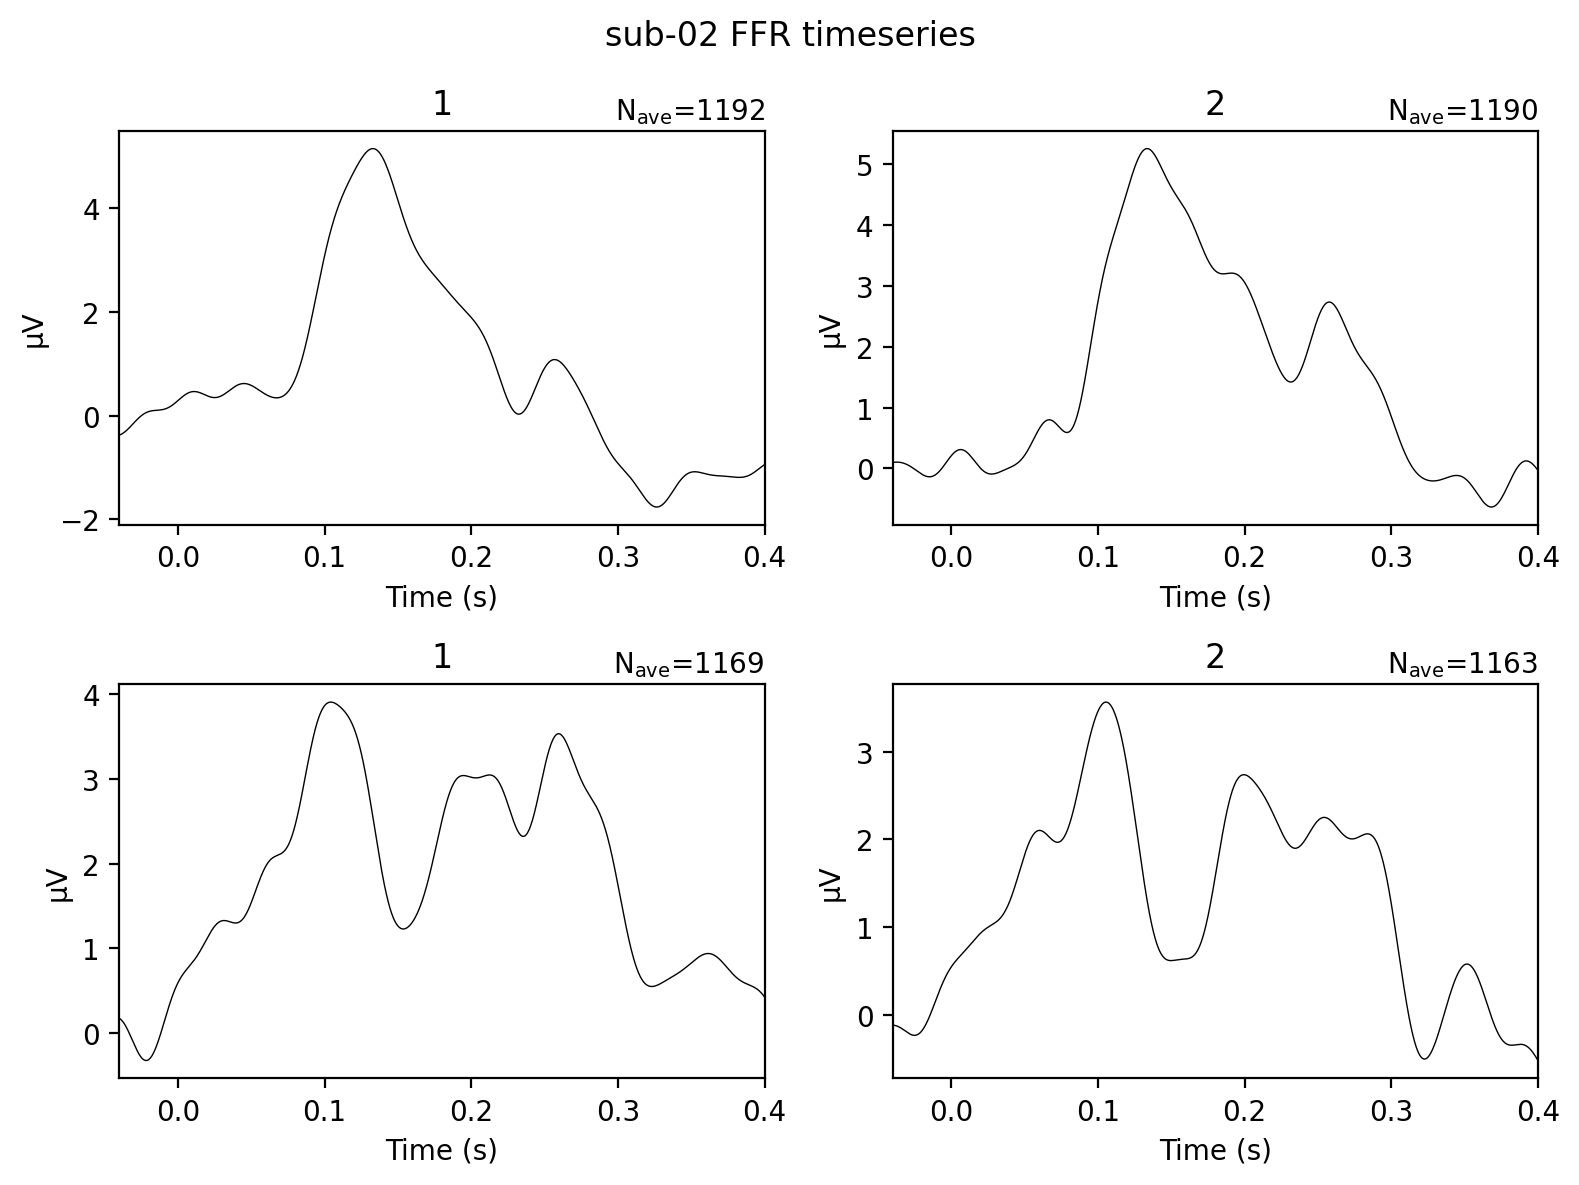

In [44]:
# Waveforms
fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
event_evoked_dict['passive'][0].plot(axes=ax[0], selectable=False, show=False)
event_evoked_dict['passive'][1].plot(axes=ax[1], selectable=False, show=False)
event_evoked_dict['active'][0].plot(axes=ax[2], selectable=False, show=False)
event_evoked_dict['active'][1].plot(axes=ax[3], selectable=False, show=False)

ax[0].set_title(event_evoked_dict['passive'][0].comment);
ax[1].set_title(event_evoked_dict['passive'][1].comment);
ax[2].set_title(event_evoked_dict['active'][0].comment);
ax[3].set_title(event_evoked_dict['active'][1].comment);

fig.suptitle(f'sub-{sub_label} FFR timeseries')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_timeseries.svg')

In [ ]:
# Power spectra
passive_pos_psd = event_evoked_dict['passive'][0].compute_psd(tmin=0.05, tmax=0.200, fmin=50, fmax=800)
passive_neg_psd = event_evoked_dict['passive'][1].compute_psd(tmin=0.05, tmax=0.200, fmin=50, fmax=800)
active_pos_psd = event_evoked_dict['active'][0].compute_psd(tmin=0.05, tmax=0.200, fmin=50, fmax=800)
active_neg_psd = event_evoked_dict['active'][1].compute_psd(tmin=0.05, tmax=0.200, fmin=50, fmax=800)

fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
passive_pos_psd.plot(axes=ax[0], amplitude=False, average=True, show=False)
passive_neg_psd.plot(axes=ax[1], amplitude=False, average=True, show=False)
active_pos_psd.plot(axes=ax[2], amplitude=False, average=True, show=False)
active_neg_psd.plot(axes=ax[3], amplitude=False, average=True, show=False)

ax[0].set_title(event_evoked_dict['passive'][0].comment);
ax[1].set_title(event_evoked_dict['passive'][1].comment);
ax[2].set_title(event_evoked_dict['active'][0].comment);
ax[3].set_title(event_evoked_dict['active'][1].comment);

fig.suptitle(f'sub-{sub_label} FFR power spectra')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

In [ ]:
# Spectrograms
frequencies = np.arange(70,350)

passive_pos_power = event_evoked_dict['passive'][0].compute_tfr("morlet", freqs=frequencies)
passive_neg_power = event_evoked_dict['passive'][1].compute_tfr("morlet", freqs=frequencies)
active_pos_power = event_evoked_dict['active'][0].compute_tfr("morlet", freqs=frequencies)
active_neg_power = event_evoked_dict['active'][1].compute_tfr("morlet", freqs=frequencies)

fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
passive_pos_power.plot(axes=ax[0], show=False)
passive_neg_power.plot(axes=ax[1], show=False)
active_pos_power.plot(axes=ax[2], show=False)
active_neg_power.plot(axes=ax[3], show=False)

ax[0].set_title(event_evoked_dict['passive'][0].comment);
ax[1].set_title(event_evoked_dict['passive'][1].comment);
ax[2].set_title(event_evoked_dict['active'][0].comment);
ax[3].set_title(event_evoked_dict['active'][1].comment);

fig.suptitle(f'sub-{sub_label} FFR spectrograms')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectrograms.svg')

### Plot combined polarities

In [45]:
task_evoked_dict

{'passive': <Evoked | 'Grand average (n = 66)' (average, N=66), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 'active': <Evoked | 'Grand average (n = 66)' (average, N=66), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>}

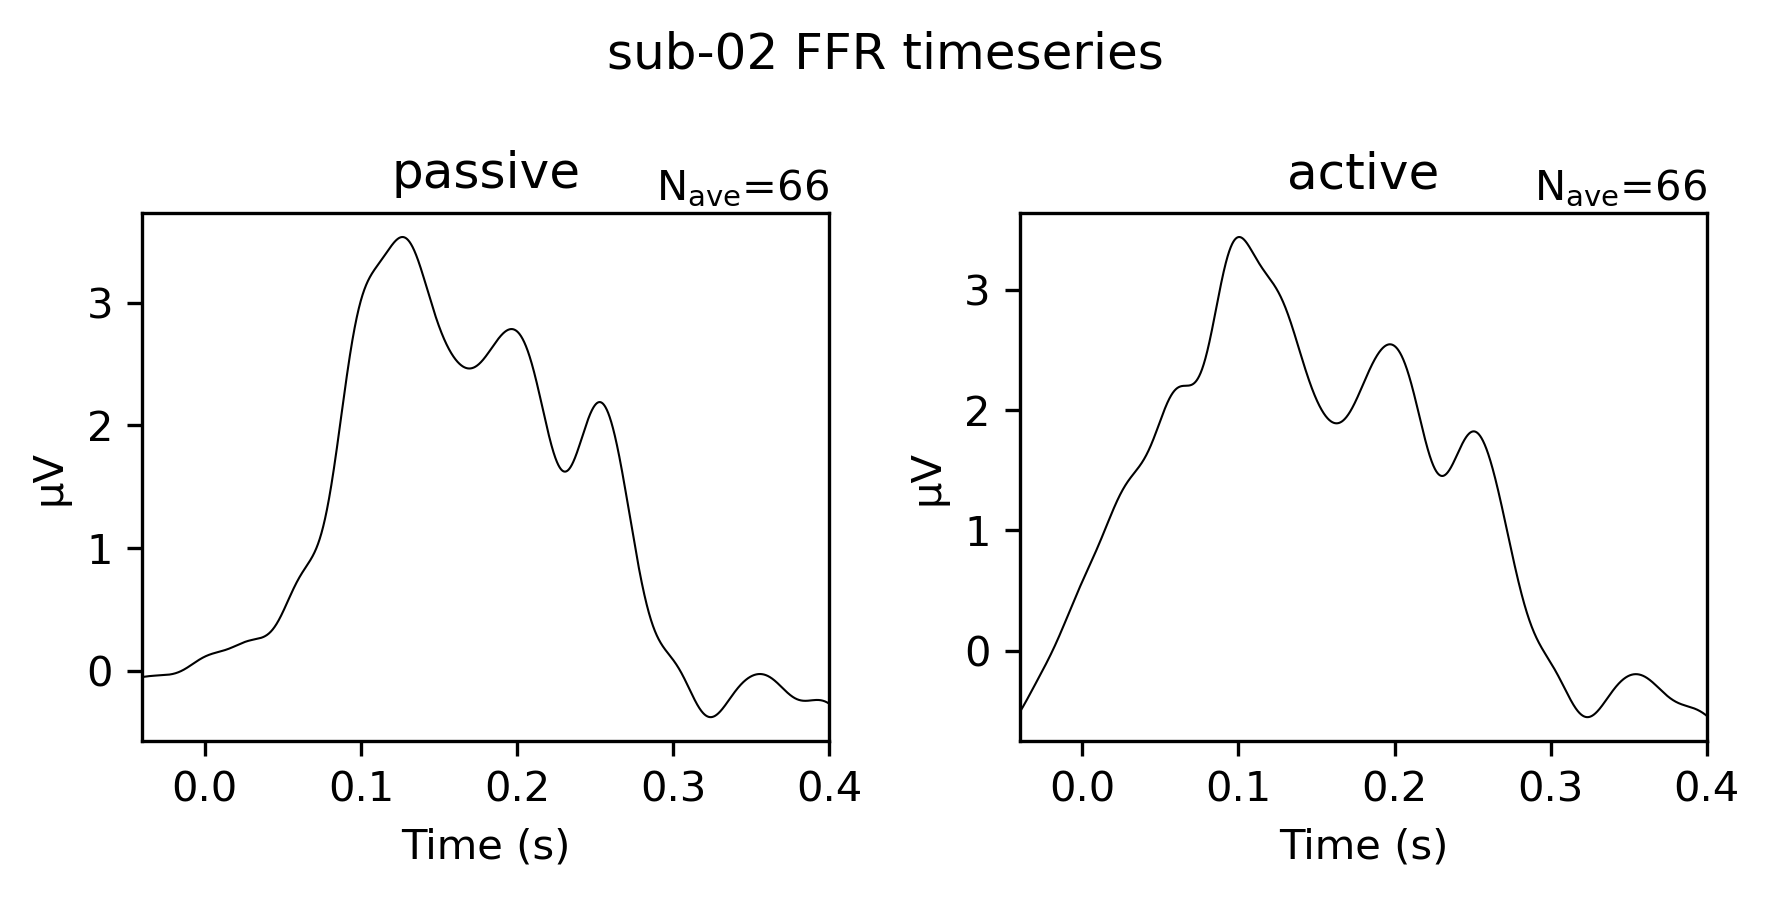

<Figure size 640x480 with 0 Axes>

In [46]:
# Waveforms
fig, ax = plt.subplots(1, 2, figsize=(6,3), dpi=300)
task_evoked_dict['passive'].plot(axes=ax[0], selectable=False, show=False)
task_evoked_dict['active'].plot(axes=ax[1], selectable=False, show=False)

ax[0].set_title('passive');
ax[1].set_title('active');

fig.suptitle(f'sub-{sub_label} FFR timeseries')

fig.tight_layout()
plt.show()
plt.savefig(f'sub-{sub_label}_timeseries.svg')

In [ ]:
# Power spectra
passive_psd = task_evoked_dict['passive'].compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
active_psd = task_evoked_dict['active'].compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
fig, ax = plt.subplots(1, 2, figsize=(6,3), dpi=300)
passive_psd.plot(axes=ax[0], amplitude=False, average=True, show=False)
active_psd.plot(axes=ax[1], amplitude=False, average=True, show=False)

ax[0].set_title('passive');
ax[1].set_title('active');

fig.suptitle(f'sub-{sub_label} FFR power spectra')

fig.tight_layout()
plt.show()
plt.savefig(f'sub-{sub_label}_spectra.svg')

In [ ]:
# Spectrograms
frequencies = np.arange(70,350)
active_power =  task_evoked_dict['active'].compute_tfr("morlet", freqs=frequencies)
passive_power =  task_evoked_dict['passive'].compute_tfr("morlet", freqs=frequencies)
fig, ax = plt.subplots(1, 2, figsize=(6,3), dpi=300)
passive_power.plot(axes=ax[0], show=False)
active_power.plot(axes=ax[1], show=False)

ax[0].set_title('passive');
ax[1].set_title('active');

fig.suptitle(f'sub-{sub_label} FFR spectrograms')

fig.tight_layout()
plt.show()
plt.savefig(f'sub-{sub_label}_spectrograms.svg')

# QA and metrics

## RMS SNR

In [76]:
from numpy import mean, sqrt, square, arange

In [ ]:
for sx, stim in enumerate(task_evoked_dict):
    s_evoked = task_evoked_dict[stim]
    baseline_ind_bounds = s_evoked.time_as_index(task_evoked_dict[stim].baseline)
    response_ind_bounds = s_evoked.time_as_index([0.05, 0.200])

    evoked_baseline = s_evoked.data[0,baseline_ind_bounds[0]:baseline_ind_bounds[1]]
    evoked_response = s_evoked.data[0,response_ind_bounds[0]:response_ind_bounds[1]]
    rms_baseline = sqrt(mean(square(evoked_baseline)))
    rms_response = sqrt(mean(square(evoked_response)))

    rms_snr = rms_response / rms_baseline

    print(f'{stim} RMS SNR: {rms_snr:.04f}')
print(f'\nMean RMS SNR: {rms_snr.mean():.04f}' )

## [IN PREP] Autocorrelation

In [42]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [43]:
acf, confint = sm.tsa.stattools.acf(all_evoked.data[0,:], 
                                    nlags=len(all_evoked.data[0,:])-1,
                                    alpha=.05)

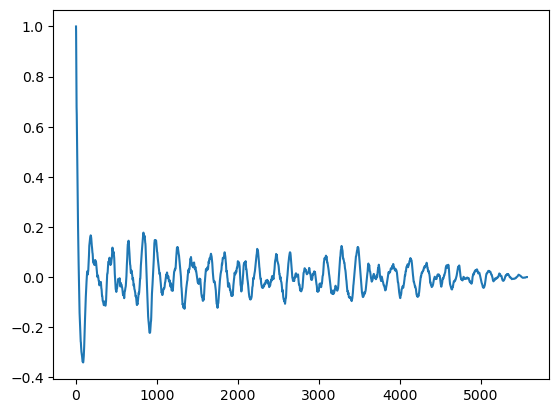

In [44]:
plt.plot(acf)
plt.show()

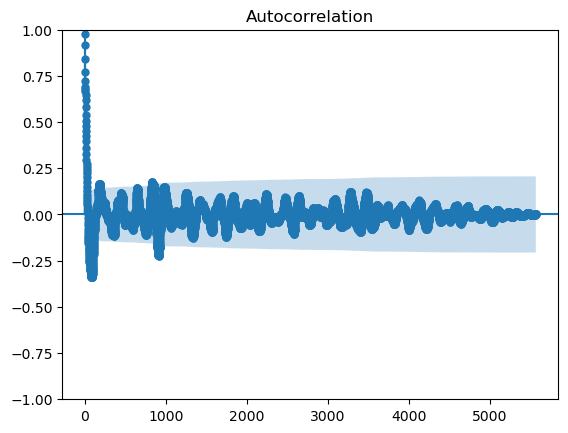

In [45]:
sm.graphics.tsa.plot_acf(all_evoked.data[0,:], 
                         lags=len(all_evoked.data[0,:])-1, 
                         zero=False,)

## [IN PREP] Stimulus–response correlations


In [46]:
data.pick(['Erg1'])

Measurement date,"July 18, 2024 13:12:19 GMT"
Experimenter,Unknown
Participant,
Digitized points,Not available
Good channels,1 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,16384.00 Hz
Highpass,0.00 Hz
Lowpass,3334.00 Hz


In [47]:
# epoch data based on stimulus events
stim_epochs = mne.Epochs(data_filtered, 
                    events, 
                    event_id=event_dict,
                    picks=['Erg1'],
                    tmin=-0.04, tmax=0.3, 
                    baseline=[-0.04, 0],
                    #reject = dict(eeg = 35e-6)).drop_bad()
                    reject=dict(eeg=75)).drop_bad()

Not setting metadata
1170 matching events found
Setting baseline interval to [-0.04, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1170 events and 5571 original time points ...
0 bad epochs dropped


In [48]:
stim_epochs

Number of events,1170
Events,button_press: 1170
Time range,-0.040 – 0.300 s
Baseline,-0.040 – 0.000 s


In [49]:
stim_epochs.average()

Condition,button_press
Data kind,average
Timepoints,5571 samples
Channels,1 channels
Number of averaged epochs,1170
Time range (secs),-0.03997802734375 – 0.29998779296875
Baseline (secs),-0.040 – 0.000 s


Need more than one channel to make topography for eeg. Disabling interactivity.


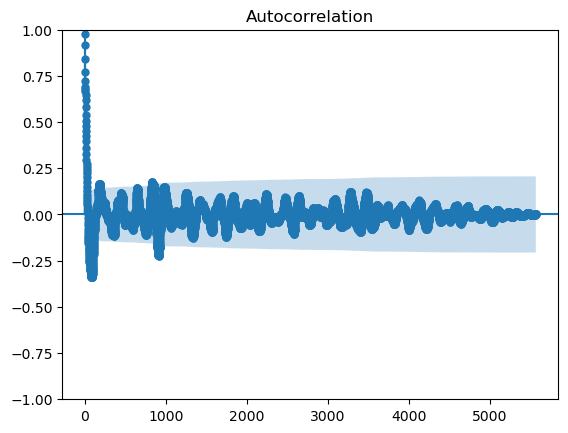

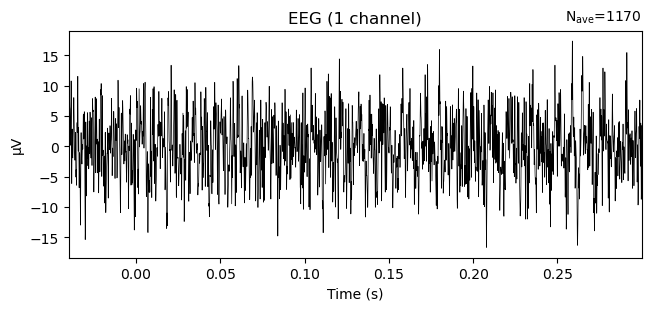

In [50]:
stim_epochs.average().plot();

In [51]:
stim_data = stim_epochs.average().get_data()[0,:]
active_data = task_evoked_dict['active'].get_data()[0,:]
passive_data = task_evoked_dict['passive'].get_data()[0,:]

In [78]:
np.array(range(len(stim_data)))

array([   0,    1,    2, ..., 5568, 5569, 5570])

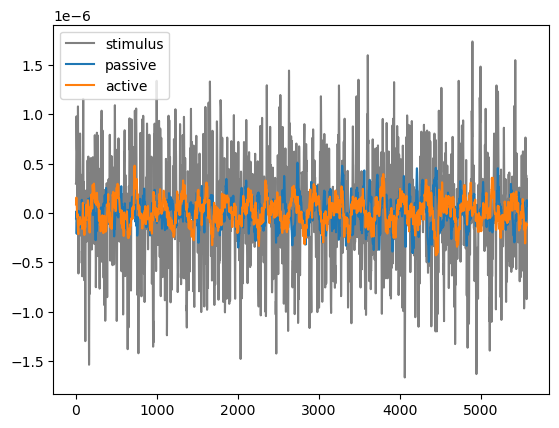

In [86]:
plt.plot(stim_data/10, color='grey')
plt.plot(passive_data)
plt.plot(active_data)
plt.legend(['stimulus','passive','active'])
#plt.xaxis(np.array(range(len(stim_data)))/16384)
plt.show()

In [52]:
from scipy.stats import spearmanr
active_res = spearmanr(active_data, stim_data, alternative='greater')
passive_res = spearmanr(passive_data, stim_data, alternative='greater')


In [53]:
active_res

SignificanceResult(statistic=0.013488523482214512, pvalue=0.15706554806619186)

In [54]:
passive_res

SignificanceResult(statistic=-0.0022353155565718644, pvalue=0.5662381718955769)